In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.ndimage import label
from PIL import Image
from collections import Counter
df = pd.read_json("data/training_json/ISIC_0000000_features.json")
spmask = np.array(Image.open("data/training_superpixels/ISIC_0000000_superpixels.png"))

In [ ]:
def decode_sp_index(rgb_val):
    red = rgb_val[0]
    green = rgb_val[1]
    blue = rgb_val[2]
    return red + (green << 8) + (blue << 16)

In [ ]:
def visualize(img_file, sp_file, json_file, rgb=(0,0,0), opacity=30):
    df = pd.read_json(json_file)
    spmask = np.array(Image.open(sp_file))
    indices = np.empty((spmask.shape[:2]))
    for x in range(spmask.shape[0]):
        for y in range(spmask.shape[1]):
            indices[x,y] = decode_sp_index(spmask[x,y])
    fig, axes = plt.subplots(2,2, figsize=(16,12))
    for col, ax in zip(list(df), axes.flatten()):
        arr = np.empty_like(indices, dtype=bool)
        for i, val in enumerate(df[col]):
            arr[np.where(indices == i)] = not val
        mask = np.uint8(np.stack([np.full_like(arr, c, dtype=int) for c in rgb] + [(~arr)*opacity], axis=2))
        mask = Image.fromarray(mask)
        mask.thumbnail((600, 600), resample=False)
        img = Image.open(img_file).convert("RGBA")
        img.paste(mask, mask=mask)
        ax.imshow(np.array(img))
        ax.axis("off")
        ax.set_title(col)


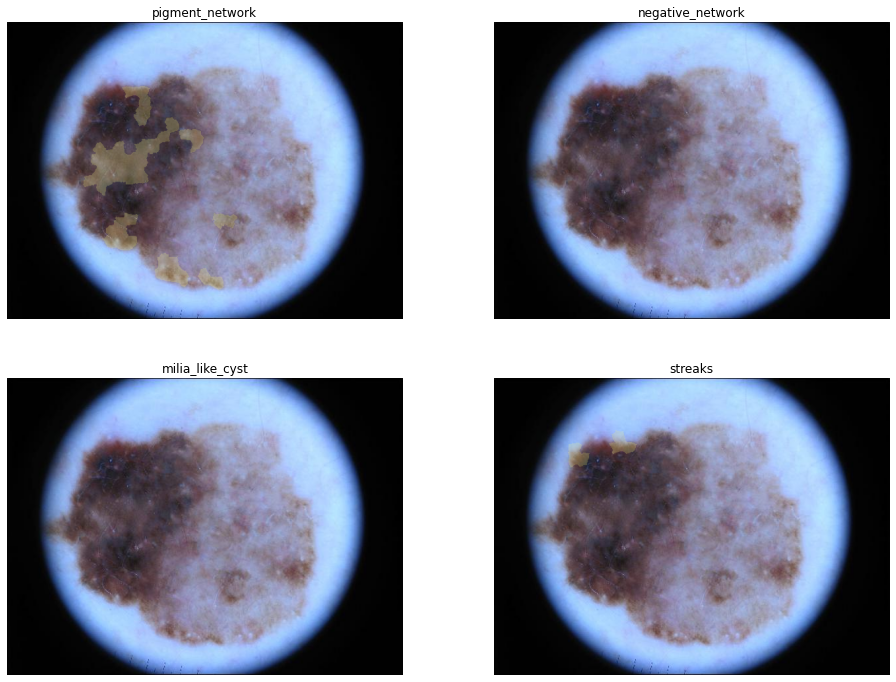

In [ ]:
img_id = "ISIC_0000036"
img_file = f"resized_data/training_image_resized/{img_id}.jpg"
sp_file = f"data/training_superpixels/{img_id}_superpixels.png"
json_file = f"data/training_json/{img_id}_features.json"
visualize(img_file, sp_file, json_file, rgb=(255, 255, 0))

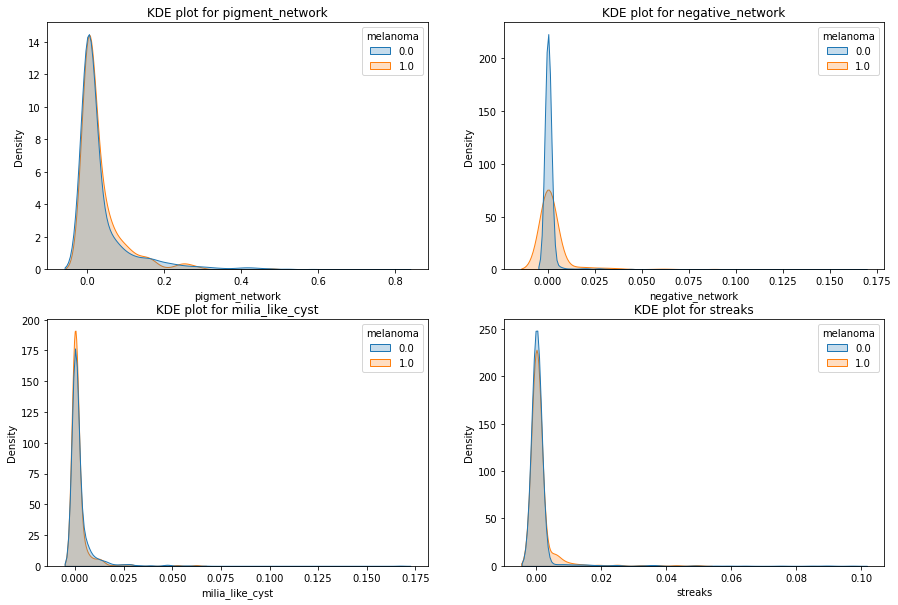

In [ ]:
df = pd.read_csv("data/training_ground_truth.csv").drop("seborrheic_keratosis", axis=1)
features = []
for img_id in df["image_id"]:
    json_file = f"data/training_json/{img_id}_features.json"
    jdf = pd.read_json(json_file)
    percentages = []
    for col in list(jdf):
        percentages.append(np.sum(jdf[col]) / len(jdf[col]))
    features.append(percentages)
feature_arr = np.vstack(features)
for i, col in enumerate(list(jdf)):
    df[col] = feature_arr[:,i]
df.to_csv("features/json_features_training.csv", index=False)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features = list(df)[2:]
for feature, ax in zip(features, axes.flatten()):
    sns.kdeplot(feature, data=df, hue="melanoma", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE plot for {feature}")

In [ ]:
def labels(sp_file, json_file):
    df = pd.read_json(json_file)
    spmask = Image.open(sp_file)
    spmask.thumbnail((100, 100), resample=False)
    spmask = np.array(spmask)
    indices = np.empty((spmask.shape[:2]))
    for x in range(spmask.shape[0]):
        for y in range(spmask.shape[1]):
            indices[x,y] = decode_sp_index(spmask[x,y])
    for col in list(df):
        arr = np.empty_like(indices, dtype=int)
        for i, val in enumerate(df[col]):
            arr[np.where(indices == i)] = int(val)
        structure = np.ones((3, 3))
        labels, _ = label(arr, structure=structure)
        print(np.unique(labels, return_counts=True))

In [ ]:
img_id = "ISIC_0000036"
img_file = f"resized_data/training_image_resized/{img_id}.jpg"
sp_file = f"data/training_superpixels/{img_id}_superpixels.png"
json_file = f"data/training_json/{img_id}_features.json"
labels(sp_file, json_file)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([7135,   39,  191,   52,   17,   46,   20]))
(array([0], dtype=int32), array([7500]))
(array([0], dtype=int32), array([7500]))
(array([0, 1, 2], dtype=int32), array([7452,   24,   24]))


In [ ]:
def label_json(spmask, df):
    indices = np.empty((spmask.shape[:2]))
    label_arrays = []
    for x in range(spmask.shape[0]):
        for y in range(spmask.shape[1]):
            indices[x, y] = decode_sp_index(spmask[x, y])
    for col in list(df):
        arr = np.empty_like(indices, dtype=int)
        for i, val in enumerate(df[col]):
            arr[np.where(indices == i)] = int(val)
        structure = np.ones((3, 3))
        labels, _ = label(arr, structure=structure)
        label_arrays.append(labels)
    return label_arrays

In [ ]:
df = pd.read_csv("data/training_ground_truth.csv").drop(columns="seborrheic_keratosis")
img_names = list(df["image_id"])
pigment_network = []
negative_network = []
milia_like = []
streaks = []
for img in img_names:
    spmask = Image.open(f"data/training_superpixels/{img}_superpixels.png")
    spmask.thumbnail((100, 100), resample=False)
    spmask = np.array(spmask)
    json_df = pd.read_json(f"data/training_json/{img}_features.json")
    label_arrays = label_json(spmask, json_df)
    for arr, li in zip(label_arrays, [pigment_network, negative_network, milia_like, streaks]):
        li.append(arr)

In [ ]:
pigment_counts = np.hstack([np.unique(arr[arr > 0], return_counts=True)[1] for arr in pigment_network])

<AxesSubplot:ylabel='Density'>

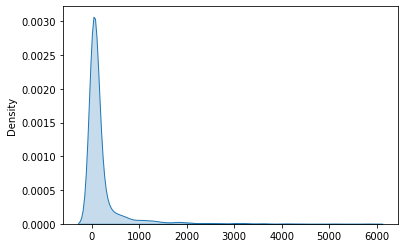

In [ ]:
sns.kdeplot(x=pigment_counts, fill=True)

In [ ]:
bins = [np.quantile(pigment_counts, n/10) for n in range(0, 10, 1)]
np.histogram(pigment_counts, bins=bins)

(array([257, 305, 283, 274, 317, 285, 294, 285, 293]),
 array([  1.,   9.,  16.,  23.,  31.,  44.,  63., 100., 176., 502.]))

In [ ]:
for feat_list in [pigment_network, negative_network, milia_like, streaks]:
    counts = np.hstack([np.unique(arr[arr > 0], return_counts=True)[1] for arr in feat_list])
    bins = [np.quantile(counts, n/10) for n in range(0, 10, 1)]
    print(np.histogram(counts, bins=bins))
    print()

(array([257, 305, 283, 274, 317, 285, 294, 285, 293]), array([  1.,   9.,  16.,  23.,  31.,  44.,  63., 100., 176., 502.]))

(array([21, 28, 24, 24, 24, 25, 25, 24, 24]), array([  4. ,  14. ,  20.6,  26.9,  34. ,  43. ,  63.4,  90.1, 143.4,
       223.1]))

(array([141, 260, 318,   0, 388, 316, 273, 270, 287]), array([ 2.,  6.,  7.,  8.,  8.,  9., 10., 13., 17., 26.]))

(array([28, 32, 28, 31, 28, 30, 31, 29, 31]), array([  5. ,   8. ,  12.2,  18. ,  24.4,  31. ,  40. ,  52.2,  74.6,
       106. ]))



In [80]:
from handin.feature_functions import hist_json
df = pd.read_csv("data/training_ground_truth.csv").drop(columns="seborrheic_keratosis")
df = df.head(500)
img_names = list(df["image_id"])
features = {'pigment_network': [], 'negative_network': [], 'milia_like_cyst': [], 'streaks': []}
for img in img_names:
    spmask = Image.open(f"data/training_superpixels/{img}_superpixels.png")
    spmask.thumbnail((100, 100), resample=False)
    spmask = np.array(spmask)
    json_df = pd.read_json(f"data/training_json/{img}_features.json")
    hists = hist_json(spmask, json_df)
    for feat, hist in zip(list(json_df), hists):
        features[feat].append(hist)
for feat, col in features.items():
    print(col)
    df[feat] = col

[array([0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 0, 0, 1, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 1, 0, 0, 1, 0]), array([1, 0, 0, 0, 0, 1, 1, 0, 0]), array([0, 0, 1, 2, 0, 0, 0, 1, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 0, 0, 0, 0, 0, 0]), array([1, 0, 1, 1, 2, 1, 0, 1, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 1, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 2]), array([0, 0, 0, 1, 1, 0, 2, 2, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0,

KNN Accuracy scores
acc_score: 0.750 ±0.00
auc_score: 0.500 ±0.00
______________________________
Decision Tree Accuracy scores
acc_score: 0.750 ±0.00
auc_score: 0.500 ±0.24

Confusion matrix for threshold 0.3
[[1. 0.]
 [1. 0.]]


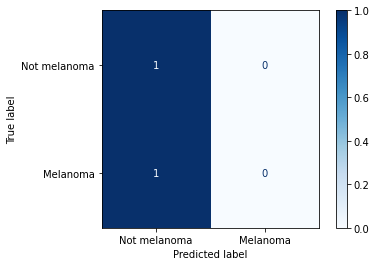

In [121]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def to_numpy(arr):
    return np.array(arr[1:-1].split(), dtype=int)

converters = {'pigment_network_hist': to_numpy, 'negative_network_hist': to_numpy, 'milia_like_cyst_hist': to_numpy, 'streaks_hist': to_numpy}

df = pd.read_csv("features/json_train.csv", converters=converters)
features = list(df.drop(columns=["image_id", "melanoma"]))
x = np.hstack([np.vstack(df[feat].to_numpy()) for feat in features])

# x = StandardScaler().fit_transform(x)

y = np.array(df["melanoma"])

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 5
threshold = 0.3


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>